# **CS 1810 Homework 5**
---
To account for potential version issues, try the following in your terminal:

1. Create a new environment with `python3 -m venv venv`
2. Activate that environment with `source venv/bin/activate`
3. Make sure the interpreter in the top right corner of your VSCode (or whatever you use to run your code is venv).
4. If you get a "install kernel" message, press it.
5. Run `pip install -r requirements.txt`
6. Run the remainder of this notebook.

Note that this is not necessary but can help prevent any issues due to package versions.

**The following notebook is meant to help you work through Problems 2 and 3 on Homework 5. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


## Problem 2

#### Initialize data and parameters

Consider a specific example of when we have $K = 3$ component Gamma distributions. Let's initialize the initial parameter values for $\theta$ and $\beta_k$ as follows:
$$
\begin{align*}
  \theta_k &=  1/K, \\
  \beta_k & = k/K.
\end{align*}
$$

Note that we usually initialize $\theta$ and $\beta_k$ randomly. However, by fixing the initial $\theta$ and $\beta_k$, EM becomes deterministic which makes debugging (and grading) easier.



In [199]:
import torch
import torch.distributions as ds
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [200]:
K = 3
# Load in the data
x = torch.load('data.pt').reshape((-1, 1))
theta = torch.tensor([1/3 for _ in range(3)])
betas = torch.tensor([k / 3 for k in range(1, K + 1)])

# uncomment to use numpy (optional)
import numpy as np
from scipy.stats import gamma
x = x.numpy()
theta = theta.numpy()
betas = betas.numpy()

print(x.shape)

(2000, 1)


### Part 1

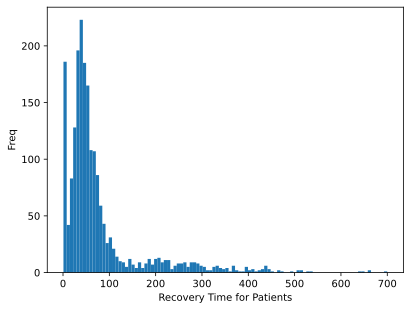

In [201]:
# YOUR CODE HERE
plt.hist(x, bins = 100)
plt.xlabel("Recovery Time for Patients")
plt.ylabel("Freq")
plt.savefig("img_output/p2_1_data.pdf", bbox_inches = 'tight')



### Part 2

#### **Todo:** implement the E-step

In [202]:
alpha = 5.0
x = x.flatten()

In [203]:
from scipy.special import logsumexp

def e_step(theta, betas):
    K = len(theta)
    q = []
    for i in range(len(x)):
        log_weights = np.array([np.log(theta[k]) + gamma.logpdf(x[i], a=alpha, scale=1/betas[k]) for k in range(K)])
        log_weights -= logsumexp(log_weights)
        q.append(np.exp(log_weights))
    return np.array(q)
        

#### **Todo:** implement the M-step

In [204]:
def m_step(q):
    N, K = q.shape
    theta_update = np.sum(q, axis = 0) / N
    betas_update = (alpha * np.sum(q, axis = 0)) / np.dot(x,q)
    return theta_update, betas_update
    

#### **Todo:** implement log likelihood

In [205]:
def log_px(x, theta, betas):
    K = len(theta)
    log_probs = np.array([np.log(theta[k]) + gamma.logpdf(x, a=alpha, scale=1/betas[k]) for k in range(K)])
    return logsumexp(log_probs, axis=0)


def log_likelihood(theta, betas):
    # YOUR CODE HERE
    return np.sum(log_px(x, theta, betas))

#### **Todo:** implement EM algorithm

In [206]:
def run_em(theta, betas, iterations=1000, verbose=True):
    # YOUR CODE HERE
    for i in range(iterations):
        q = e_step(theta, betas)
        theta, betas = m_step(q)
    return theta, betas


### Part 3

In [207]:
def make_overlay_plot(theta, betas):
    x_test = torch.linspace(0.01, x.max(), 1000)
    # prob = log_px(x_test.unsqueeze(-1), theta, betas).exp()
    prob = np.exp(log_px(x_test.unsqueeze(-1), theta, betas))  # use this line for numpy
    ll = log_likelihood(theta, betas)
    
    fig, ax = plt.subplots(figsize=(5, 3))
    fig.subplots_adjust(top=0.7)
    fig.suptitle(f'theta = {theta}\nbeta = {betas}\nlog likelihood = {ll:.3e}')
    
    ax.hist(x, bins=100, color='tomato', alpha=0.5, density=True, label='Dataset')
    ax.plot(x_test, prob, color='royalblue', label='Gamma mixture')
    
    ax.set_title(f'Dataset and Gamma mixture (K={len(theta)})')
    ax.set_xlabel('Recovery time (hours)')
    ax.set_ylabel('Density')
    ax.legend()

In [208]:
alpha = 5.0
for K in range(1,5):
    theta0 = (torch.ones(K) / K).numpy()
    betas0 = ((torch.arange(K) + 1) / K).numpy()
    theta, betas = run_em(theta0, betas0, verbose=False)
    make_overlay_plot(theta, betas)
    plt.savefig(f'img_output/p2_3_{K}mixtures.pdf', bbox_inches='tight')

KeyboardInterrupt: 

---
## Problem 3

#### Initialize data:

In [215]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)  # download MNIST
N = 6000 

x = mnist_trainset.data[:N]  # select N datapoints
x = x.flatten(1)             # flatten the images
x = x.float()                # convert pixels from uint8 to float
x = x.numpy()              # uncomment to use numpy (optional)

#### **Todo:** implement PCA

*Hint: see `.linalg.svd()`*

In [233]:
def pca(x, n_comps=500):
    x_centered = x - np.mean(x, axis=0)
    U, S, Vt = np.linalg.svd(x_centered, full_matrices=False)
    pcomps = Vt[:n_comps, :]
    eigvals = (S**2)[:n_comps]

    return eigvals, pcomps


#### **Todo:** calculate cumulative fraction of variance

*Hint: see `.cumsum()`*

In [234]:
def calc_cfvs(eigvals):
    cfv = np.cumsum(eigvals) / np.sum(eigvals)
    return cfv

#### **Todo:** calculate mean squared L2 norm reconstruction losses

In [235]:
def calc_errs(x, pcomps):
    x_centered = x - np.mean(x, axis=0)

    x_recon_mean = np.zeros_like(x_centered)
    err_mean = np.mean(np.linalg.norm(x_centered - x_recon_mean, axis=1) ** 2)

    x_proj = np.dot(x_centered, pcomps.T)
    x_recon_pca = np.dot(x_proj, pcomps)
    err_pcomp = np.mean(np.linalg.norm(x_centered - x_recon_pca, axis=1) ** 2)

    return err_mean, err_pcomp


#### Plot and print errors:

In [236]:
def plot_pic(pic, ax, title=''):
    x = pic.reshape(28, 28)
    ax.imshow(x, cmap='binary')
    ax.set_title(title)
    ax.axis('off')

def make_plots(eigvals, cfvs, x_mean, pcomps):
    # plot eigenvals and cfvs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    ax1.plot(eigvals, color='tomato')
    ax1.set_title('Eigenvalues')
    ax2.plot(cfvs, color='tomato')
    ax2.set_title('CFVs')
    fig.savefig('img_output/p3_cfvs.pdf', bbox_inches = 'tight')

    # plot mean
    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    plot_pic(x_mean, ax, title='Mean')
    fig.savefig('img_output/p3_mean.pdf', bbox_inches = 'tight')

    # plot top 10 pcomps
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i in range(10):
        plot_pic(pcomps[i], axes.flat[i], title=f'PC index {i}')
    fig.savefig('img_output/p3_pcomps.pdf', bbox_inches = 'tight')

Reconstruction error (using mean): 3.436024e+06
Reconstruction error (using mean and top 10 pcomps): 1.731315e+06


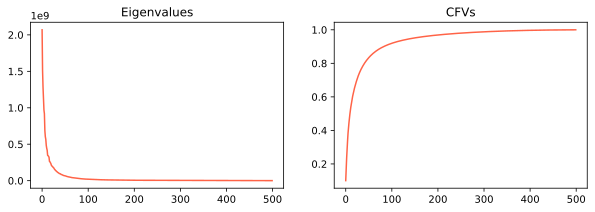

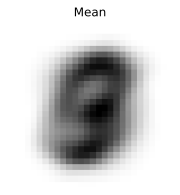

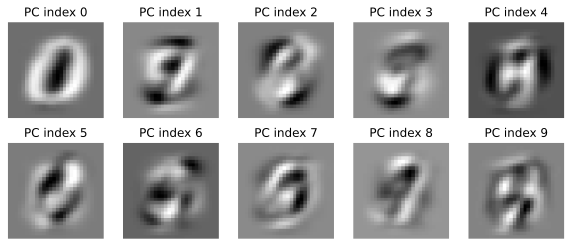

In [237]:
# do PCA
eigvals, pcomps = pca(x)

# calculate CFVs
fcvs = calc_cfvs(eigvals)

first10 = pcomps[:10, :]

# print errors
err_mean, err_pcomp = calc_errs(x, first10)
print(f'Reconstruction error (using mean): {err_mean:3e}')  # 3.436022e+06
print(f'Reconstruction error (using mean and top 10 pcomps): {err_pcomp:3e}')  # 1.731315e+06

# make plots
make_plots(eigvals, fcvs, x.mean(0), pcomps)
